In [1]:
from pandas_datareader import data as pdr
import pandas as pd
import numpy as np
import cvxpy as cvx
from scipy.stats import norm
from numpy.linalg import inv
import math

import keras
import seaborn as sns
import sklearn
import tensorflow as tf

# for plotting
import plotly
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import cufflinks as cf
import matplotlib.pyplot as plt

# Initialize plotly offline
plotly.offline.init_notebook_mode(connected=True)

from benchmarks import *

Using TensorFlow backend.


## Normalization

In [6]:
def normalized(data):
    data_temp = data - np.mean(data)
    variance = np.sum(data ** 2)/len(data)
    data_temp /= variance
    return data_temp

## Load stock data

### US Stocks

In [7]:
us_stocks = ['SPY', # The SP500 as a benchmark
             'AAPL', 'MMM', 'BA' , 'CAT', 'CVX' , 'CSCO', 'KO' , 'DIS',
             'GS', 'IBM', 'INTC', 'JNJ', 'JPM', 'MSFT', 'PFE'] #Some stocks from the Dow Jones

start_data = '2008-09-01'
end_date = '2008-10-01'

In [8]:
# download_stock_data(start_data, end_date, us_stocks, 'us_stocks_latest')

In [9]:
# read in the data again
us_stock_prices = pd.read_csv('./00_Data/us_stocks_latest.csv', header=0, index_col = 0)
us_stock_prices.index = pd.to_datetime(us_stock_prices.index)

#Process Stock Data
us_stock_relative_prices, us_stock_returns = process_stock_data(us_stock_prices)

# Extract benchmark SP500 Data
SPY_relative_price_benchmark = us_stock_relative_prices.drop(us_stocks[1:], axis=1)
SPY_returns_benchmark = us_stock_returns.drop(us_stocks[1:], axis=1)
us_stock_prices_norm_wo_SPY = us_stock_relative_prices.drop(us_stocks[0], axis=1)

# filter out benchmark data from stock returns
us_stock_returns = us_stock_returns.drop(us_stocks[0], axis=1)

### Hundred stocks

In [10]:
# Read in the data
hundred_stock_prices = pd.read_csv('./00_Data/hundred_stocks.csv', header=0, index_col = 0)

In [11]:
hundred_stock_prices.index = pd.to_datetime(hundred_stock_prices.index)

#Process Stock Data
# hundred_stock_relative_prices, hundred_stock_returns = process_stock_data(hundred_stock_prices)

#Read processed data to save time
hundred_stock_relative_prices = pd.read_csv('./00_Data/hundred_stock_relative_prices.csv', header=0, index_col = 0)
hundred_stock_returns = pd.read_csv('./00_Data/hundred_stock_returns.csv', header=0, index_col = 0)

#### SPY

In [12]:
# download_stock_data('2001-01-02', '2019-07-17', ['SPY'], 'SPY_same_dates_as_hundred_stocks')

In [13]:
# Read in the data
SPY_prices = pd.read_csv('./00_Data/SPY_same_dates_as_hundred_stocks.csv', header=0, index_col = 0)

In [14]:
SPY_prices.index = pd.to_datetime(hundred_stock_prices.index)

#Process Stock Data
SPY_relative_prices, SPY_returns = process_stock_data(SPY_prices)

### Subprime mortgage crisis period data

In [15]:
subprime_mortgage_crisis = hundred_stock_prices.loc['2008-09'].dropna(axis=1) 
SPMC_relative_prices, SPMC_returns = process_stock_data(subprime_mortgage_crisis) # H_i,t of each asset i for t = 1,...,20

In [16]:
SPMC_SPY_relative_price_benchmark = SPY_relative_price_benchmark.loc['2008-09']

# Directions: Deep portfolio using neural network

Next we are to implement the deep portfolio. Recall the four step procedure: 
- **Auto-encoding**: this phase is essentially dimension reduction. *In the paper: one hidden layer with five neurons*.
- **Calibration**: using the stock price of the first few years, our target index $Y$ is the S&P500 (we can also play with this target so that the portfolio map can possibly outperform S&P500 -- but this is for later). *In the paper: ReLU and 4-fold cross validation*. 
- **Validation**: out-sample validation. Will need to test with different number of stocks.
- **Verification**: deep frontier. We look at the 2-norm out-of-sample error for different number of stocks used.

## 1. Auto-encoding

**Used Data**: 
- SPMC_returns: 20 daily returns during September of 2008 calculated with hundred_stocks.

**NN Model**: 
- 87 - 5 - 87

In [17]:
# Import `Sequential` from `keras.models`
from keras.models import Sequential
from keras.optimizers import RMSprop
opt = RMSprop(lr=0.001)

# Import `Dense` from `keras.layers`
from keras.layers import Dense

### Constructing model

In [18]:
# Initialize the constructor
autoencoder_model = Sequential()

#input 87 stock data, and the hidden layer has 5 neurons; no biased involved (unless we let use_bias = TRUE)
autoencoder_model.add(Dense(units = 5, input_dim = 87, activation='relu', use_bias = False))
autoencoder_model.add(Dense(units = 87, activation='relu', use_bias = False))

W0813 17:14:07.330052 4683789760 deprecation_wrapper.py:119] From /usr/local/Cellar/python/3.7.3/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0813 17:14:07.332066 4683789760 deprecation_wrapper.py:119] From /usr/local/Cellar/python/3.7.3/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0813 17:14:07.335951 4683789760 deprecation_wrapper.py:119] From /usr/local/Cellar/python/3.7.3/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



### Set optimizer and learning rate

In [19]:
# autoencoder_opt = RMSprop(lr=0.001)

### Compile & Learn

In [20]:
autoencoder_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

W0813 17:14:08.745255 4683789760 deprecation_wrapper.py:119] From /usr/local/Cellar/python/3.7.3/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [21]:
autoencoder_model.fit(SPMC_returns, SPMC_returns, epochs = 1500)

W0813 17:14:09.038072 4683789760 deprecation_wrapper.py:119] From /usr/local/Cellar/python/3.7.3/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0813 17:14:09.073882 4683789760 deprecation_wrapper.py:119] From /usr/local/Cellar/python/3.7.3/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Epoch 1/5000
20/20 [==============================] - 0s 6ms/step - loss: 2.2345 - mean_absolute_error: 0.9304
Epoch 2/5000
20/20 [==============================] - 0s 73us/step - loss: 2.2216 - mean_absolute_error: 0.9235
Epoch 3/5000
20/20 [==============================] - 0s 57us/step - loss: 2.2096 - mean_absolute_error: 0.9163
Epoch 4/5000
20/20 [==============================] - 0s 66us/step - loss: 2.1977 - mean_absolute_error: 0.9094
Epoch 5/5000
20/20 [==============================] - 0s 62us/step - loss: 2.1875 - mean_absolute_error: 0.9027
Epoch 6/5000
20/20 [==============================] - 0s 63us/step - loss: 2.1773 - mean_absolute_error: 0.8959
Epoch 7/5000
20/20 [==============================] - 0s 65us/step - loss: 2.1671 - mean_absolute_error: 0.8889
Epoch 8/5000
20/20 [==============================] - 0s 67us/step - loss: 2.1570 - mean_absolute_error: 0.8817
Epoch 9/5000
20/20 [==============================] - 0s 67us/step - loss: 2.1470 - mean_absolute_error: 

Epoch 74/5000
20/20 [==============================] - 0s 80us/step - loss: 1.8063 - mean_absolute_error: 0.5881
Epoch 75/5000
20/20 [==============================] - 0s 101us/step - loss: 1.8034 - mean_absolute_error: 0.5855
Epoch 76/5000
20/20 [==============================] - 0s 102us/step - loss: 1.8005 - mean_absolute_error: 0.5830
Epoch 77/5000
20/20 [==============================] - 0s 99us/step - loss: 1.7977 - mean_absolute_error: 0.5805
Epoch 78/5000
20/20 [==============================] - 0s 79us/step - loss: 1.7949 - mean_absolute_error: 0.5779
Epoch 79/5000
20/20 [==============================] - 0s 99us/step - loss: 1.7922 - mean_absolute_error: 0.5753
Epoch 80/5000
20/20 [==============================] - 0s 81us/step - loss: 1.7895 - mean_absolute_error: 0.5727
Epoch 81/5000
20/20 [==============================] - 0s 64us/step - loss: 1.7869 - mean_absolute_error: 0.5701
Epoch 82/5000
20/20 [==============================] - 0s 71us/step - loss: 1.7843 - mean_abso

Epoch 146/5000
20/20 [==============================] - 0s 115us/step - loss: 1.6529 - mean_absolute_error: 0.5144
Epoch 147/5000
20/20 [==============================] - 0s 61us/step - loss: 1.6507 - mean_absolute_error: 0.5146
Epoch 148/5000
20/20 [==============================] - 0s 63us/step - loss: 1.6485 - mean_absolute_error: 0.5149
Epoch 149/5000
20/20 [==============================] - 0s 69us/step - loss: 1.6462 - mean_absolute_error: 0.5151
Epoch 150/5000
20/20 [==============================] - 0s 110us/step - loss: 1.6439 - mean_absolute_error: 0.5154
Epoch 151/5000
20/20 [==============================] - 0s 72us/step - loss: 1.6416 - mean_absolute_error: 0.5157
Epoch 152/5000
20/20 [==============================] - 0s 73us/step - loss: 1.6393 - mean_absolute_error: 0.5159
Epoch 153/5000
20/20 [==============================] - 0s 66us/step - loss: 1.6370 - mean_absolute_error: 0.5162
Epoch 154/5000
20/20 [==============================] - 0s 99us/step - loss: 1.6347 - 

Epoch 218/5000
20/20 [==============================] - 0s 169us/step - loss: 1.4537 - mean_absolute_error: 0.5424
Epoch 219/5000
20/20 [==============================] - 0s 81us/step - loss: 1.4508 - mean_absolute_error: 0.5432
Epoch 220/5000
20/20 [==============================] - 0s 115us/step - loss: 1.4475 - mean_absolute_error: 0.5432
Epoch 221/5000
20/20 [==============================] - 0s 96us/step - loss: 1.4442 - mean_absolute_error: 0.5426
Epoch 222/5000
20/20 [==============================] - 0s 79us/step - loss: 1.4411 - mean_absolute_error: 0.5423
Epoch 223/5000
20/20 [==============================] - 0s 67us/step - loss: 1.4380 - mean_absolute_error: 0.5423
Epoch 224/5000
20/20 [==============================] - 0s 96us/step - loss: 1.4348 - mean_absolute_error: 0.5424
Epoch 225/5000
20/20 [==============================] - 0s 86us/step - loss: 1.4316 - mean_absolute_error: 0.5427
Epoch 226/5000
20/20 [==============================] - 0s 74us/step - loss: 1.4283 - 

Epoch 290/5000
20/20 [==============================] - 0s 94us/step - loss: 1.1963 - mean_absolute_error: 0.5301
Epoch 291/5000
20/20 [==============================] - 0s 196us/step - loss: 1.1923 - mean_absolute_error: 0.5301
Epoch 292/5000
20/20 [==============================] - 0s 152us/step - loss: 1.1882 - mean_absolute_error: 0.5295
Epoch 293/5000
20/20 [==============================] - 0s 69us/step - loss: 1.1841 - mean_absolute_error: 0.5282
Epoch 294/5000
20/20 [==============================] - 0s 76us/step - loss: 1.1802 - mean_absolute_error: 0.5272
Epoch 295/5000
20/20 [==============================] - 0s 65us/step - loss: 1.1761 - mean_absolute_error: 0.5265
Epoch 296/5000
20/20 [==============================] - 0s 94us/step - loss: 1.1719 - mean_absolute_error: 0.5262
Epoch 297/5000
20/20 [==============================] - 0s 58us/step - loss: 1.1677 - mean_absolute_error: 0.5260
Epoch 298/5000
20/20 [==============================] - 0s 62us/step - loss: 1.1640 - 

Epoch 362/5000
20/20 [==============================] - 0s 111us/step - loss: 0.9057 - mean_absolute_error: 0.4764
Epoch 363/5000
20/20 [==============================] - 0s 225us/step - loss: 0.9019 - mean_absolute_error: 0.4763
Epoch 364/5000
20/20 [==============================] - 0s 99us/step - loss: 0.8980 - mean_absolute_error: 0.4763
Epoch 365/5000
20/20 [==============================] - 0s 141us/step - loss: 0.8949 - mean_absolute_error: 0.4764
Epoch 366/5000
20/20 [==============================] - 0s 114us/step - loss: 0.8914 - mean_absolute_error: 0.4762
Epoch 367/5000
20/20 [==============================] - 0s 110us/step - loss: 0.8877 - mean_absolute_error: 0.4756
Epoch 368/5000
20/20 [==============================] - 0s 150us/step - loss: 0.8836 - mean_absolute_error: 0.4747
Epoch 369/5000
20/20 [==============================] - 0s 163us/step - loss: 0.8802 - mean_absolute_error: 0.4738
Epoch 370/5000
20/20 [==============================] - 0s 99us/step - loss: 0.87

Epoch 434/5000
20/20 [==============================] - 0s 63us/step - loss: 0.6679 - mean_absolute_error: 0.4526
Epoch 435/5000
20/20 [==============================] - 0s 62us/step - loss: 0.6654 - mean_absolute_error: 0.4522
Epoch 436/5000
20/20 [==============================] - 0s 103us/step - loss: 0.6630 - mean_absolute_error: 0.4521
Epoch 437/5000
20/20 [==============================] - 0s 110us/step - loss: 0.6605 - mean_absolute_error: 0.4521
Epoch 438/5000
20/20 [==============================] - 0s 101us/step - loss: 0.6579 - mean_absolute_error: 0.4521
Epoch 439/5000
20/20 [==============================] - 0s 93us/step - loss: 0.6553 - mean_absolute_error: 0.4521
Epoch 440/5000
20/20 [==============================] - 0s 88us/step - loss: 0.6527 - mean_absolute_error: 0.4521
Epoch 441/5000
20/20 [==============================] - 0s 71us/step - loss: 0.6505 - mean_absolute_error: 0.4520
Epoch 442/5000
20/20 [==============================] - 0s 93us/step - loss: 0.6482 -

Epoch 506/5000
20/20 [==============================] - 0s 83us/step - loss: 0.5234 - mean_absolute_error: 0.4448
Epoch 507/5000
20/20 [==============================] - 0s 100us/step - loss: 0.5219 - mean_absolute_error: 0.4446
Epoch 508/5000
20/20 [==============================] - 0s 84us/step - loss: 0.5204 - mean_absolute_error: 0.4444
Epoch 509/5000
20/20 [==============================] - 0s 70us/step - loss: 0.5190 - mean_absolute_error: 0.4443
Epoch 510/5000
20/20 [==============================] - 0s 73us/step - loss: 0.5177 - mean_absolute_error: 0.4441
Epoch 511/5000
20/20 [==============================] - 0s 76us/step - loss: 0.5163 - mean_absolute_error: 0.4440
Epoch 512/5000
20/20 [==============================] - 0s 172us/step - loss: 0.5148 - mean_absolute_error: 0.4440
Epoch 513/5000
20/20 [==============================] - 0s 113us/step - loss: 0.5135 - mean_absolute_error: 0.4440
Epoch 514/5000
20/20 [==============================] - 0s 87us/step - loss: 0.5121 -

Epoch 578/5000
20/20 [==============================] - 0s 163us/step - loss: 0.4517 - mean_absolute_error: 0.4393
Epoch 579/5000
20/20 [==============================] - 0s 126us/step - loss: 0.4512 - mean_absolute_error: 0.4393
Epoch 580/5000
20/20 [==============================] - 0s 72us/step - loss: 0.4506 - mean_absolute_error: 0.4392
Epoch 581/5000
20/20 [==============================] - 0s 124us/step - loss: 0.4499 - mean_absolute_error: 0.4391
Epoch 582/5000
20/20 [==============================] - 0s 97us/step - loss: 0.4494 - mean_absolute_error: 0.4390
Epoch 583/5000
20/20 [==============================] - 0s 146us/step - loss: 0.4488 - mean_absolute_error: 0.4389
Epoch 584/5000
20/20 [==============================] - 0s 119us/step - loss: 0.4482 - mean_absolute_error: 0.4389
Epoch 585/5000
20/20 [==============================] - 0s 61us/step - loss: 0.4477 - mean_absolute_error: 0.4388
Epoch 586/5000
20/20 [==============================] - 0s 64us/step - loss: 0.4471

Epoch 650/5000
20/20 [==============================] - 0s 94us/step - loss: 0.4250 - mean_absolute_error: 0.4358
Epoch 651/5000
20/20 [==============================] - 0s 74us/step - loss: 0.4248 - mean_absolute_error: 0.4358
Epoch 652/5000
20/20 [==============================] - 0s 133us/step - loss: 0.4246 - mean_absolute_error: 0.4358
Epoch 653/5000
20/20 [==============================] - 0s 69us/step - loss: 0.4244 - mean_absolute_error: 0.4357
Epoch 654/5000
20/20 [==============================] - 0s 82us/step - loss: 0.4242 - mean_absolute_error: 0.4357
Epoch 655/5000
20/20 [==============================] - 0s 115us/step - loss: 0.4241 - mean_absolute_error: 0.4356
Epoch 656/5000
20/20 [==============================] - 0s 60us/step - loss: 0.4239 - mean_absolute_error: 0.4356
Epoch 657/5000
20/20 [==============================] - 0s 76us/step - loss: 0.4237 - mean_absolute_error: 0.4356
Epoch 658/5000
20/20 [==============================] - 0s 73us/step - loss: 0.4235 - 

Epoch 722/5000
20/20 [==============================] - 0s 95us/step - loss: 0.4174 - mean_absolute_error: 0.4341
Epoch 723/5000
20/20 [==============================] - 0s 107us/step - loss: 0.4173 - mean_absolute_error: 0.4341
Epoch 724/5000
20/20 [==============================] - 0s 64us/step - loss: 0.4173 - mean_absolute_error: 0.4341
Epoch 725/5000
20/20 [==============================] - 0s 87us/step - loss: 0.4172 - mean_absolute_error: 0.4340
Epoch 726/5000
20/20 [==============================] - 0s 97us/step - loss: 0.4172 - mean_absolute_error: 0.4340
Epoch 727/5000
20/20 [==============================] - 0s 94us/step - loss: 0.4171 - mean_absolute_error: 0.4340
Epoch 728/5000
20/20 [==============================] - 0s 176us/step - loss: 0.4171 - mean_absolute_error: 0.4340
Epoch 729/5000
20/20 [==============================] - 0s 81us/step - loss: 0.4171 - mean_absolute_error: 0.4340
Epoch 730/5000
20/20 [==============================] - 0s 68us/step - loss: 0.4170 - 

Epoch 794/5000
20/20 [==============================] - 0s 185us/step - loss: 0.4157 - mean_absolute_error: 0.4333
Epoch 795/5000
20/20 [==============================] - 0s 75us/step - loss: 0.4157 - mean_absolute_error: 0.4333
Epoch 796/5000
20/20 [==============================] - 0s 82us/step - loss: 0.4156 - mean_absolute_error: 0.4333
Epoch 797/5000
20/20 [==============================] - 0s 68us/step - loss: 0.4156 - mean_absolute_error: 0.4333
Epoch 798/5000
20/20 [==============================] - 0s 68us/step - loss: 0.4156 - mean_absolute_error: 0.4333
Epoch 799/5000
20/20 [==============================] - 0s 77us/step - loss: 0.4156 - mean_absolute_error: 0.4333
Epoch 800/5000
20/20 [==============================] - 0s 87us/step - loss: 0.4156 - mean_absolute_error: 0.4333
Epoch 801/5000
20/20 [==============================] - 0s 77us/step - loss: 0.4156 - mean_absolute_error: 0.4332
Epoch 802/5000
20/20 [==============================] - 0s 90us/step - loss: 0.4156 - m

Epoch 866/5000
20/20 [==============================] - 0s 69us/step - loss: 0.4154 - mean_absolute_error: 0.4330
Epoch 867/5000
20/20 [==============================] - 0s 147us/step - loss: 0.4154 - mean_absolute_error: 0.4330
Epoch 868/5000
20/20 [==============================] - 0s 84us/step - loss: 0.4154 - mean_absolute_error: 0.4330
Epoch 869/5000
20/20 [==============================] - 0s 89us/step - loss: 0.4154 - mean_absolute_error: 0.4330
Epoch 870/5000
20/20 [==============================] - 0s 64us/step - loss: 0.4153 - mean_absolute_error: 0.4330
Epoch 871/5000
20/20 [==============================] - 0s 72us/step - loss: 0.4153 - mean_absolute_error: 0.4330
Epoch 872/5000
20/20 [==============================] - 0s 73us/step - loss: 0.4153 - mean_absolute_error: 0.4330
Epoch 873/5000
20/20 [==============================] - 0s 83us/step - loss: 0.4153 - mean_absolute_error: 0.4330
Epoch 874/5000
20/20 [==============================] - 0s 98us/step - loss: 0.4153 - m

Epoch 938/5000
20/20 [==============================] - 0s 117us/step - loss: 0.4153 - mean_absolute_error: 0.4329
Epoch 939/5000
20/20 [==============================] - 0s 145us/step - loss: 0.4153 - mean_absolute_error: 0.4329
Epoch 940/5000
20/20 [==============================] - 0s 140us/step - loss: 0.4153 - mean_absolute_error: 0.4328
Epoch 941/5000
20/20 [==============================] - 0s 73us/step - loss: 0.4153 - mean_absolute_error: 0.4328
Epoch 942/5000
20/20 [==============================] - 0s 86us/step - loss: 0.4153 - mean_absolute_error: 0.4328
Epoch 943/5000
20/20 [==============================] - 0s 86us/step - loss: 0.4153 - mean_absolute_error: 0.4328
Epoch 944/5000
20/20 [==============================] - 0s 102us/step - loss: 0.4153 - mean_absolute_error: 0.4328
Epoch 945/5000
20/20 [==============================] - 0s 144us/step - loss: 0.4153 - mean_absolute_error: 0.4328
Epoch 946/5000
20/20 [==============================] - 0s 66us/step - loss: 0.4153

Epoch 1010/5000
20/20 [==============================] - 0s 66us/step - loss: 0.4153 - mean_absolute_error: 0.4328
Epoch 1011/5000
20/20 [==============================] - 0s 88us/step - loss: 0.4153 - mean_absolute_error: 0.4328
Epoch 1012/5000
20/20 [==============================] - 0s 165us/step - loss: 0.4153 - mean_absolute_error: 0.4328
Epoch 1013/5000
20/20 [==============================] - 0s 84us/step - loss: 0.4153 - mean_absolute_error: 0.4328
Epoch 1014/5000
20/20 [==============================] - 0s 112us/step - loss: 0.4153 - mean_absolute_error: 0.4328
Epoch 1015/5000
20/20 [==============================] - 0s 107us/step - loss: 0.4153 - mean_absolute_error: 0.4328
Epoch 1016/5000
20/20 [==============================] - 0s 107us/step - loss: 0.4153 - mean_absolute_error: 0.4328
Epoch 1017/5000
20/20 [==============================] - 0s 73us/step - loss: 0.4153 - mean_absolute_error: 0.4328
Epoch 1018/5000
20/20 [==============================] - 0s 76us/step - loss

20/20 [==============================] - 0s 90us/step - loss: 0.4153 - mean_absolute_error: 0.4328
Epoch 1082/5000
20/20 [==============================] - 0s 132us/step - loss: 0.4153 - mean_absolute_error: 0.4328
Epoch 1083/5000
20/20 [==============================] - 0s 69us/step - loss: 0.4153 - mean_absolute_error: 0.4328
Epoch 1084/5000
20/20 [==============================] - 0s 68us/step - loss: 0.4153 - mean_absolute_error: 0.4328
Epoch 1085/5000
20/20 [==============================] - 0s 68us/step - loss: 0.4153 - mean_absolute_error: 0.4328
Epoch 1086/5000
20/20 [==============================] - 0s 59us/step - loss: 0.4153 - mean_absolute_error: 0.4328
Epoch 1087/5000
20/20 [==============================] - 0s 81us/step - loss: 0.4153 - mean_absolute_error: 0.4328
Epoch 1088/5000
20/20 [==============================] - 0s 106us/step - loss: 0.4153 - mean_absolute_error: 0.4328
Epoch 1089/5000
20/20 [==============================] - 0s 57us/step - loss: 0.4153 - mean_ab

Epoch 1153/5000
20/20 [==============================] - 0s 57us/step - loss: 0.4153 - mean_absolute_error: 0.4328
Epoch 1154/5000
20/20 [==============================] - 0s 68us/step - loss: 0.4153 - mean_absolute_error: 0.4328
Epoch 1155/5000
20/20 [==============================] - 0s 57us/step - loss: 0.4153 - mean_absolute_error: 0.4328
Epoch 1156/5000
20/20 [==============================] - 0s 118us/step - loss: 0.4153 - mean_absolute_error: 0.4328
Epoch 1157/5000
20/20 [==============================] - 0s 74us/step - loss: 0.4153 - mean_absolute_error: 0.4328
Epoch 1158/5000
20/20 [==============================] - 0s 155us/step - loss: 0.4153 - mean_absolute_error: 0.4328
Epoch 1159/5000
20/20 [==============================] - 0s 61us/step - loss: 0.4153 - mean_absolute_error: 0.4328
Epoch 1160/5000
20/20 [==============================] - 0s 85us/step - loss: 0.4153 - mean_absolute_error: 0.4328
Epoch 1161/5000
20/20 [==============================] - 0s 64us/step - loss: 

20/20 [==============================] - 0s 89us/step - loss: 0.4153 - mean_absolute_error: 0.4328
Epoch 1225/5000
20/20 [==============================] - 0s 83us/step - loss: 0.4153 - mean_absolute_error: 0.4328
Epoch 1226/5000
20/20 [==============================] - 0s 108us/step - loss: 0.4153 - mean_absolute_error: 0.4328
Epoch 1227/5000
20/20 [==============================] - 0s 151us/step - loss: 0.4153 - mean_absolute_error: 0.4328
Epoch 1228/5000
20/20 [==============================] - 0s 85us/step - loss: 0.4153 - mean_absolute_error: 0.4328
Epoch 1229/5000
20/20 [==============================] - 0s 83us/step - loss: 0.4153 - mean_absolute_error: 0.4328
Epoch 1230/5000
20/20 [==============================] - 0s 58us/step - loss: 0.4153 - mean_absolute_error: 0.4328
Epoch 1231/5000
20/20 [==============================] - 0s 82us/step - loss: 0.4153 - mean_absolute_error: 0.4328
Epoch 1232/5000
20/20 [==============================] - 0s 87us/step - loss: 0.4153 - mean_ab

Epoch 1296/5000
20/20 [==============================] - 0s 66us/step - loss: 0.4153 - mean_absolute_error: 0.4327
Epoch 1297/5000
20/20 [==============================] - 0s 192us/step - loss: 0.4153 - mean_absolute_error: 0.4327
Epoch 1298/5000
20/20 [==============================] - 0s 90us/step - loss: 0.4153 - mean_absolute_error: 0.4327
Epoch 1299/5000
20/20 [==============================] - 0s 139us/step - loss: 0.4153 - mean_absolute_error: 0.4327
Epoch 1300/5000
20/20 [==============================] - 0s 81us/step - loss: 0.4153 - mean_absolute_error: 0.4327
Epoch 1301/5000
20/20 [==============================] - 0s 80us/step - loss: 0.4153 - mean_absolute_error: 0.4327
Epoch 1302/5000
20/20 [==============================] - 0s 88us/step - loss: 0.4153 - mean_absolute_error: 0.4327
Epoch 1303/5000
20/20 [==============================] - 0s 110us/step - loss: 0.4153 - mean_absolute_error: 0.4327
Epoch 1304/5000
20/20 [==============================] - 0s 106us/step - loss

20/20 [==============================] - 0s 82us/step - loss: 0.4153 - mean_absolute_error: 0.4327
Epoch 1368/5000
20/20 [==============================] - 0s 61us/step - loss: 0.4153 - mean_absolute_error: 0.4327
Epoch 1369/5000
20/20 [==============================] - 0s 62us/step - loss: 0.4153 - mean_absolute_error: 0.4327
Epoch 1370/5000
20/20 [==============================] - 0s 146us/step - loss: 0.4153 - mean_absolute_error: 0.4327
Epoch 1371/5000
20/20 [==============================] - 0s 69us/step - loss: 0.4153 - mean_absolute_error: 0.4327
Epoch 1372/5000
20/20 [==============================] - 0s 109us/step - loss: 0.4153 - mean_absolute_error: 0.4327
Epoch 1373/5000
20/20 [==============================] - 0s 71us/step - loss: 0.4153 - mean_absolute_error: 0.4327
Epoch 1374/5000
20/20 [==============================] - 0s 63us/step - loss: 0.4153 - mean_absolute_error: 0.4327
Epoch 1375/5000
20/20 [==============================] - 0s 67us/step - loss: 0.4153 - mean_ab

Epoch 1439/5000
20/20 [==============================] - 0s 79us/step - loss: 0.4153 - mean_absolute_error: 0.4327
Epoch 1440/5000
20/20 [==============================] - 0s 71us/step - loss: 0.4153 - mean_absolute_error: 0.4327
Epoch 1441/5000
20/20 [==============================] - 0s 77us/step - loss: 0.4153 - mean_absolute_error: 0.4327
Epoch 1442/5000
20/20 [==============================] - 0s 145us/step - loss: 0.4153 - mean_absolute_error: 0.4327
Epoch 1443/5000
20/20 [==============================] - 0s 93us/step - loss: 0.4153 - mean_absolute_error: 0.4327
Epoch 1444/5000
20/20 [==============================] - 0s 96us/step - loss: 0.4153 - mean_absolute_error: 0.4327
Epoch 1445/5000
20/20 [==============================] - 0s 74us/step - loss: 0.4153 - mean_absolute_error: 0.4327
Epoch 1446/5000
20/20 [==============================] - 0s 87us/step - loss: 0.4153 - mean_absolute_error: 0.4327
Epoch 1447/5000
20/20 [==============================] - 0s 70us/step - loss: 0

20/20 [==============================] - 0s 109us/step - loss: 0.4153 - mean_absolute_error: 0.4327
Epoch 1511/5000
20/20 [==============================] - 0s 79us/step - loss: 0.4153 - mean_absolute_error: 0.4327
Epoch 1512/5000
20/20 [==============================] - 0s 88us/step - loss: 0.4153 - mean_absolute_error: 0.4327
Epoch 1513/5000
20/20 [==============================] - 0s 60us/step - loss: 0.4153 - mean_absolute_error: 0.4327
Epoch 1514/5000
20/20 [==============================] - 0s 80us/step - loss: 0.4153 - mean_absolute_error: 0.4327
Epoch 1515/5000
20/20 [==============================] - 0s 103us/step - loss: 0.4153 - mean_absolute_error: 0.4327
Epoch 1516/5000
20/20 [==============================] - 0s 81us/step - loss: 0.4153 - mean_absolute_error: 0.4327
Epoch 1517/5000
20/20 [==============================] - 0s 75us/step - loss: 0.4153 - mean_absolute_error: 0.4327
Epoch 1518/5000
20/20 [==============================] - 0s 82us/step - loss: 0.4153 - mean_ab

Epoch 1582/5000
20/20 [==============================] - 0s 69us/step - loss: 0.4153 - mean_absolute_error: 0.4327
Epoch 1583/5000
20/20 [==============================] - 0s 112us/step - loss: 0.4153 - mean_absolute_error: 0.4327
Epoch 1584/5000
20/20 [==============================] - 0s 76us/step - loss: 0.4153 - mean_absolute_error: 0.4327
Epoch 1585/5000
20/20 [==============================] - 0s 86us/step - loss: 0.4153 - mean_absolute_error: 0.4327
Epoch 1586/5000
20/20 [==============================] - 0s 71us/step - loss: 0.4153 - mean_absolute_error: 0.4327
Epoch 1587/5000
20/20 [==============================] - 0s 82us/step - loss: 0.4153 - mean_absolute_error: 0.4327
Epoch 1588/5000
20/20 [==============================] - 0s 84us/step - loss: 0.4153 - mean_absolute_error: 0.4327
Epoch 1589/5000
20/20 [==============================] - 0s 76us/step - loss: 0.4153 - mean_absolute_error: 0.4327
Epoch 1590/5000
20/20 [==============================] - 0s 63us/step - loss: 0

20/20 [==============================] - 0s 145us/step - loss: 0.4153 - mean_absolute_error: 0.4327
Epoch 1654/5000
20/20 [==============================] - 0s 67us/step - loss: 0.4153 - mean_absolute_error: 0.4327
Epoch 1655/5000
20/20 [==============================] - 0s 102us/step - loss: 0.4153 - mean_absolute_error: 0.4327
Epoch 1656/5000
20/20 [==============================] - 0s 65us/step - loss: 0.4153 - mean_absolute_error: 0.4327
Epoch 1657/5000
20/20 [==============================] - 0s 82us/step - loss: 0.4153 - mean_absolute_error: 0.4327
Epoch 1658/5000
20/20 [==============================] - 0s 83us/step - loss: 0.4153 - mean_absolute_error: 0.4327
Epoch 1659/5000
20/20 [==============================] - 0s 142us/step - loss: 0.4153 - mean_absolute_error: 0.4327
Epoch 1660/5000
20/20 [==============================] - 0s 82us/step - loss: 0.4153 - mean_absolute_error: 0.4327
Epoch 1661/5000
20/20 [==============================] - 0s 74us/step - loss: 0.4153 - mean_a

Epoch 1725/5000
20/20 [==============================] - 0s 69us/step - loss: 0.4153 - mean_absolute_error: 0.4327
Epoch 1726/5000
20/20 [==============================] - 0s 105us/step - loss: 0.4153 - mean_absolute_error: 0.4327
Epoch 1727/5000
20/20 [==============================] - 0s 156us/step - loss: 0.4153 - mean_absolute_error: 0.4327
Epoch 1728/5000
20/20 [==============================] - 0s 86us/step - loss: 0.4153 - mean_absolute_error: 0.4327
Epoch 1729/5000
20/20 [==============================] - 0s 72us/step - loss: 0.4153 - mean_absolute_error: 0.4327
Epoch 1730/5000
20/20 [==============================] - 0s 72us/step - loss: 0.4153 - mean_absolute_error: 0.4327
Epoch 1731/5000
20/20 [==============================] - 0s 68us/step - loss: 0.4153 - mean_absolute_error: 0.4327
Epoch 1732/5000
20/20 [==============================] - 0s 59us/step - loss: 0.4153 - mean_absolute_error: 0.4327
Epoch 1733/5000
20/20 [==============================] - 0s 61us/step - loss: 

Epoch 1796/5000
20/20 [==============================] - 0s 133us/step - loss: 0.4153 - mean_absolute_error: 0.4327
Epoch 1797/5000
20/20 [==============================] - 0s 147us/step - loss: 0.4153 - mean_absolute_error: 0.4327
Epoch 1798/5000
20/20 [==============================] - 0s 72us/step - loss: 0.4153 - mean_absolute_error: 0.4327
Epoch 1799/5000
20/20 [==============================] - 0s 101us/step - loss: 0.4153 - mean_absolute_error: 0.4327
Epoch 1800/5000
20/20 [==============================] - 0s 98us/step - loss: 0.4153 - mean_absolute_error: 0.4327
Epoch 1801/5000
20/20 [==============================] - 0s 91us/step - loss: 0.4153 - mean_absolute_error: 0.4327
Epoch 1802/5000
20/20 [==============================] - 0s 89us/step - loss: 0.4153 - mean_absolute_error: 0.4327
Epoch 1803/5000
20/20 [==============================] - 0s 131us/step - loss: 0.4153 - mean_absolute_error: 0.4327
Epoch 1804/5000
20/20 [==============================] - 0s 88us/step - loss

Epoch 1867/5000
20/20 [==============================] - 0s 87us/step - loss: 0.4153 - mean_absolute_error: 0.4327
Epoch 1868/5000
20/20 [==============================] - 0s 94us/step - loss: 0.4153 - mean_absolute_error: 0.4327
Epoch 1869/5000
20/20 [==============================] - 0s 112us/step - loss: 0.4153 - mean_absolute_error: 0.4327
Epoch 1870/5000
20/20 [==============================] - 0s 87us/step - loss: 0.4153 - mean_absolute_error: 0.4327
Epoch 1871/5000
20/20 [==============================] - 0s 98us/step - loss: 0.4153 - mean_absolute_error: 0.4327
Epoch 1872/5000
20/20 [==============================] - 0s 88us/step - loss: 0.4153 - mean_absolute_error: 0.4327
Epoch 1873/5000
20/20 [==============================] - 0s 67us/step - loss: 0.4153 - mean_absolute_error: 0.4327
Epoch 1874/5000
20/20 [==============================] - 0s 141us/step - loss: 0.4153 - mean_absolute_error: 0.4327
Epoch 1875/5000
20/20 [==============================] - 0s 125us/step - loss:

20/20 [==============================] - 0s 72us/step - loss: 0.4153 - mean_absolute_error: 0.4326
Epoch 1939/5000
20/20 [==============================] - 0s 102us/step - loss: 0.4153 - mean_absolute_error: 0.4326
Epoch 1940/5000
20/20 [==============================] - 0s 180us/step - loss: 0.4153 - mean_absolute_error: 0.4326
Epoch 1941/5000
20/20 [==============================] - 0s 96us/step - loss: 0.4153 - mean_absolute_error: 0.4326
Epoch 1942/5000
20/20 [==============================] - 0s 104us/step - loss: 0.4153 - mean_absolute_error: 0.4326
Epoch 1943/5000
20/20 [==============================] - 0s 123us/step - loss: 0.4153 - mean_absolute_error: 0.4326
Epoch 1944/5000
20/20 [==============================] - 0s 86us/step - loss: 0.4153 - mean_absolute_error: 0.4326
Epoch 1945/5000
20/20 [==============================] - 0s 92us/step - loss: 0.4153 - mean_absolute_error: 0.4326
Epoch 1946/5000
20/20 [==============================] - 0s 133us/step - loss: 0.4153 - mean

20/20 [==============================] - 0s 78us/step - loss: 0.4153 - mean_absolute_error: 0.4326
Epoch 2010/5000
20/20 [==============================] - 0s 98us/step - loss: 0.4153 - mean_absolute_error: 0.4326
Epoch 2011/5000
20/20 [==============================] - 0s 92us/step - loss: 0.4153 - mean_absolute_error: 0.4326
Epoch 2012/5000
20/20 [==============================] - 0s 110us/step - loss: 0.4153 - mean_absolute_error: 0.4326
Epoch 2013/5000
20/20 [==============================] - 0s 210us/step - loss: 0.4153 - mean_absolute_error: 0.4326
Epoch 2014/5000
20/20 [==============================] - 0s 105us/step - loss: 0.4153 - mean_absolute_error: 0.4326
Epoch 2015/5000
20/20 [==============================] - 0s 125us/step - loss: 0.4153 - mean_absolute_error: 0.4326
Epoch 2016/5000
20/20 [==============================] - 0s 76us/step - loss: 0.4153 - mean_absolute_error: 0.4326
Epoch 2017/5000
20/20 [==============================] - 0s 112us/step - loss: 0.4153 - mean

KeyboardInterrupt: 

### Predict

In [22]:
autoencoder_result = autoencoder_model.predict(SPMC_returns)

### Visualize

In [23]:
pd.DataFrame(autoencoder_result)

,0,1,2,3,4,5,6,7,8,9,...,77,78,79,80,81,82,83,84,85,86
0,0.997917,0.981730,0.988809,0.987897,0.980174,0.986313,0.0,0.984865,1.003520,0.0,...,0.0,0.982271,0.999775,0.987785,0.0,0.984622,0.0,0.0,0.0,0.983180
1,0.000000,0.989427,0.968826,0.948543,0.949106,0.964793,0.0,0.940436,0.959292,0.0,...,0.0,0.973753,0.972467,0.992950,0.0,0.964954,0.0,0.0,0.0,0.970663
2,1.021108,0.999336,1.006574,1.005668,0.997797,1.004035,0.0,1.002587,1.021577,0.0,...,0.0,0.999906,1.017746,1.005503,0.0,1.002312,0.0,0.0,0.0,1.000835
3,1.110396,1.004297,1.012085,1.011533,1.003469,1.009562,0.0,1.008530,1.027614,0.0,...,0.0,1.005170,1.023449,1.010542,0.0,1.007795,0.0,0.0,0.0,1.006178
4,0.971887,0.947161,0.954047,0.953205,0.945738,0.951642,0.0,0.950290,0.968288,0.0,...,0.0,0.947716,0.964642,0.953009,0.0,0.950006,0.0,0.0,0.0,0.948601
5,1.021780,1.001490,1.008736,1.007821,0.999936,1.006191,0.0,1.004732,1.023763,0.0,...,0.0,1.002056,1.019928,1.007670,0.0,1.004464,0.0,0.0,0.0,1.002987
6,1.008207,1.002167,1.009330,1.008353,1.000489,1.006778,0.0,1.005246,1.024290,0.0,...,0.0,1.002682,1.020507,1.008342,0.0,1.005056,0.0,0.0,0.0,1.003600
7,1.053431,1.011110,1.018558,1.017727,1.009726,1.015996,0.0,1.014633,1.033846,0.0,...,0.0,1.011759,1.029894,1.017361,0.0,1.014243,0.0,0.0,0.0,1.012717
8,0.947606,0.932912,0.939635,0.938765,0.931428,0.937263,0.0,0.935883,0.953610,0.0,...,0.0,0.933424,0.950055,0.938666,0.0,0.935656,0.0,0.0,0.0,0.934287
9,1.044437,1.010209,1.017601,1.016737,1.008758,1.015039,0.0,1.013636,1.032833,0.0,...,0.0,1.010829,1.028914,1.016450,0.0,1.013291,0.0,0.0,0.0,1.011779


### Percentage error

In [24]:
pd.DataFrame(abs(autoencoder_result - SPMC_returns)/SPMC_returns) * 100

,BAC,CHK,GE,AMD,NOK,CSX,TEVA,ERIC,F,WFC,...,BX,GLW,SCHW,NUS,TXT,CX,OXY,CY,NEM,FLEX
Date,,,,,,,,,,,,,,,,,,,,,
2008-09-03,3.145073,1.653133,1.257535,1.841689,1.849788,2.123420,100.0,1.425589,0.965575,100.0,...,100.0,12.341882,0.146381,0.308122,100.0,1.866813,100.0,100.0,100.0,4.060686
2008-09-04,100.000000,0.050394,0.074540,0.110601,0.100671,0.106885,100.0,0.027399,0.137491,100.0,...,100.0,0.014956,0.070301,0.009809,100.0,0.070235,100.0,100.0,100.0,0.063637
2008-09-05,3.053391,0.654783,0.007593,1.458040,7.957598,0.873300,100.0,2.696960,1.694427,100.0,...,100.0,0.548633,0.464536,1.340609,100.0,0.114464,100.0,100.0,100.0,1.530507
2008-09-08,3.046572,4.238136,3.001269,0.679815,4.029774,0.219573,100.0,0.787638,0.400542,100.0,...,100.0,1.183900,2.240717,2.026003,100.0,3.906840,100.0,100.0,100.0,2.209827
2008-09-09,3.793392,4.044013,1.304331,0.276532,4.610911,3.053389,100.0,3.211190,0.129837,100.0,...,100.0,1.792924,3.568583,2.877409,100.0,0.951825,100.0,100.0,100.0,0.509307
2008-09-10,2.556486,2.993840,0.981295,0.607693,1.652187,1.087009,100.0,1.447933,0.773053,100.0,...,100.0,1.153512,0.706710,0.774133,100.0,0.299009,100.0,100.0,100.0,0.798897
2008-09-11,1.192043,0.191720,0.682072,2.071486,2.669545,9.025043,100.0,0.717233,2.167116,100.0,...,100.0,0.330049,0.906746,1.072022,100.0,2.001954,100.0,100.0,100.0,3.374856
2008-09-12,3.219977,3.913471,7.224627,1.064707,0.777034,0.098846,100.0,1.554233,1.458287,100.0,...,100.0,0.481725,5.266601,1.496711,100.0,9.288763,100.0,100.0,100.0,0.048152
2008-09-15,20.422793,2.749151,2.175770,4.206522,4.213229,1.240326,100.0,2.515974,1.218835,100.0,...,100.0,0.344578,0.320710,4.102660,100.0,0.787832,100.0,100.0,100.0,4.187371


## 2. Calibration
#### Note: Autoencoder used daily returns; using relative prices here.
**Inputted Data**: 
- autoencoder_result: The autoencoder's representation of SPMC_returns.
- SPMC_relative_prices: 21 days of relative prices during September of 2008 calculated with hundred_stocks.
- SPMC_SPY_relative_price_benchmark: 21 days of relative prices during September of 2008.

**Important variables**:
- top10_bot10: 20 stocks that the autoencoder did the best/worst with predicting.

**NN Model**: 
- 10 - 3 - 1

### Sort & pick stocks by calculating norm2 error

In [25]:
# Error
autoencoder_prediction_error_norm2 = np.linalg.norm(abs(autoencoder_result - SPMC_returns.values), axis = 0) # Norm2 across columns
sorted_autoencoder_prediction_error_norm2 = np.sort(autoencoder_prediction_error_norm2).tolist()
sorted_stocks = [autoencoder_prediction_error_norm2.tolist().index(x) for x in sorted_autoencoder_prediction_error_norm2] # Find corresponding stocks
top10_bot10_index = sorted_stocks[:5] + sorted_stocks[-5:] # Represent stocks as original indices from norm2


In [26]:
top10_bot10 = SPMC_relative_prices.iloc[:,top10_bot10_index]

### Constructing model

In [51]:
dfp_model = Sequential()

#input 87 stock data, and the hidden layer has 5 neurons; no biased involved (unless we let use_bias = TRUE)
dfp_model.add(Dense(units = 3, input_dim = 10, activation='relu', use_bias = False))
dfp_model.add(Dense(units = 1, activation='relu', use_bias = False))


### Set optimizer and learning rate

In [52]:
dfp_opt = RMSprop(lr=0.0001) # Seems like adam is resolving problem of getting stuck at 2.0 MAE

### Compile & learn

In [53]:
dfp_model.compile(optimizer=dfp_opt, loss='mse', metrics=['mae'])

In [54]:
dfp_model.fit(top10_bot10, SPMC_SPY_relative_price_benchmark, epochs = 2000, verbose = 1)

Epoch 1/2000
21/21 [==============================] - 0s 6ms/step - loss: 0.7371 - mean_absolute_error: 0.8557
Epoch 2/2000
21/21 [==============================] - 0s 54us/step - loss: 0.7345 - mean_absolute_error: 0.8541
Epoch 3/2000
21/21 [==============================] - 0s 54us/step - loss: 0.7326 - mean_absolute_error: 0.8530
Epoch 4/2000
21/21 [==============================] - 0s 57us/step - loss: 0.7310 - mean_absolute_error: 0.8521
Epoch 5/2000
21/21 [==============================] - 0s 56us/step - loss: 0.7296 - mean_absolute_error: 0.8513
Epoch 6/2000
21/21 [==============================] - 0s 57us/step - loss: 0.7283 - mean_absolute_error: 0.8505
Epoch 7/2000
21/21 [==============================] - 0s 48us/step - loss: 0.7271 - mean_absolute_error: 0.8498
Epoch 8/2000
21/21 [==============================] - 0s 47us/step - loss: 0.7259 - mean_absolute_error: 0.8491
Epoch 9/2000
21/21 [==============================] - 0s 51us/step - loss: 0.7248 - mean_absolute_error: 

Epoch 74/2000
21/21 [==============================] - 0s 61us/step - loss: 0.6698 - mean_absolute_error: 0.8151
Epoch 75/2000
21/21 [==============================] - 0s 69us/step - loss: 0.6690 - mean_absolute_error: 0.8146
Epoch 76/2000
21/21 [==============================] - 0s 57us/step - loss: 0.6682 - mean_absolute_error: 0.8141
Epoch 77/2000
21/21 [==============================] - 0s 97us/step - loss: 0.6674 - mean_absolute_error: 0.8136
Epoch 78/2000
21/21 [==============================] - 0s 91us/step - loss: 0.6666 - mean_absolute_error: 0.8131
Epoch 79/2000
21/21 [==============================] - 0s 82us/step - loss: 0.6658 - mean_absolute_error: 0.8126
Epoch 80/2000
21/21 [==============================] - 0s 55us/step - loss: 0.6650 - mean_absolute_error: 0.8121
Epoch 81/2000
21/21 [==============================] - 0s 58us/step - loss: 0.6642 - mean_absolute_error: 0.8116
Epoch 82/2000
21/21 [==============================] - 0s 60us/step - loss: 0.6634 - mean_absolu

21/21 [==============================] - 0s 66us/step - loss: 0.6107 - mean_absolute_error: 0.7777
Epoch 147/2000
21/21 [==============================] - 0s 78us/step - loss: 0.6098 - mean_absolute_error: 0.7771
Epoch 148/2000
21/21 [==============================] - 0s 74us/step - loss: 0.6090 - mean_absolute_error: 0.7766
Epoch 149/2000
21/21 [==============================] - 0s 65us/step - loss: 0.6081 - mean_absolute_error: 0.7760
Epoch 150/2000
21/21 [==============================] - 0s 87us/step - loss: 0.6073 - mean_absolute_error: 0.7755
Epoch 151/2000
21/21 [==============================] - 0s 60us/step - loss: 0.6064 - mean_absolute_error: 0.7749
Epoch 152/2000
21/21 [==============================] - 0s 57us/step - loss: 0.6056 - mean_absolute_error: 0.7744
Epoch 153/2000
21/21 [==============================] - 0s 53us/step - loss: 0.6048 - mean_absolute_error: 0.7738
Epoch 154/2000
21/21 [==============================] - 0s 51us/step - loss: 0.6039 - mean_absolute_err

Epoch 218/2000
21/21 [==============================] - 0s 62us/step - loss: 0.5505 - mean_absolute_error: 0.7380
Epoch 219/2000
21/21 [==============================] - 0s 100us/step - loss: 0.5497 - mean_absolute_error: 0.7375
Epoch 220/2000
21/21 [==============================] - 0s 109us/step - loss: 0.5489 - mean_absolute_error: 0.7369
Epoch 221/2000
21/21 [==============================] - 0s 82us/step - loss: 0.5481 - mean_absolute_error: 0.7364
Epoch 222/2000
21/21 [==============================] - 0s 69us/step - loss: 0.5473 - mean_absolute_error: 0.7358
Epoch 223/2000
21/21 [==============================] - 0s 88us/step - loss: 0.5464 - mean_absolute_error: 0.7352
Epoch 224/2000
21/21 [==============================] - 0s 115us/step - loss: 0.5456 - mean_absolute_error: 0.7347
Epoch 225/2000
21/21 [==============================] - 0s 92us/step - loss: 0.5448 - mean_absolute_error: 0.7341
Epoch 226/2000
21/21 [==============================] - 0s 71us/step - loss: 0.5440 -

Epoch 290/2000
21/21 [==============================] - 0s 77us/step - loss: 0.4922 - mean_absolute_error: 0.6974
Epoch 291/2000
21/21 [==============================] - 0s 93us/step - loss: 0.4914 - mean_absolute_error: 0.6968
Epoch 292/2000
21/21 [==============================] - 0s 78us/step - loss: 0.4906 - mean_absolute_error: 0.6963
Epoch 293/2000
21/21 [==============================] - 0s 76us/step - loss: 0.4898 - mean_absolute_error: 0.6957
Epoch 294/2000
21/21 [==============================] - 0s 107us/step - loss: 0.4890 - mean_absolute_error: 0.6951
Epoch 295/2000
21/21 [==============================] - 0s 84us/step - loss: 0.4882 - mean_absolute_error: 0.6945
Epoch 296/2000
21/21 [==============================] - 0s 79us/step - loss: 0.4874 - mean_absolute_error: 0.6940
Epoch 297/2000
21/21 [==============================] - 0s 83us/step - loss: 0.4866 - mean_absolute_error: 0.6934
Epoch 298/2000
21/21 [==============================] - 0s 89us/step - loss: 0.4858 - m

Epoch 362/2000
21/21 [==============================] - 0s 59us/step - loss: 0.4358 - mean_absolute_error: 0.6558
Epoch 363/2000
21/21 [==============================] - 0s 81us/step - loss: 0.4350 - mean_absolute_error: 0.6552
Epoch 364/2000
21/21 [==============================] - 0s 59us/step - loss: 0.4343 - mean_absolute_error: 0.6546
Epoch 365/2000
21/21 [==============================] - 0s 69us/step - loss: 0.4335 - mean_absolute_error: 0.6540
Epoch 366/2000
21/21 [==============================] - 0s 54us/step - loss: 0.4327 - mean_absolute_error: 0.6534
Epoch 367/2000
21/21 [==============================] - 0s 109us/step - loss: 0.4320 - mean_absolute_error: 0.6528
Epoch 368/2000
21/21 [==============================] - 0s 100us/step - loss: 0.4312 - mean_absolute_error: 0.6522
Epoch 369/2000
21/21 [==============================] - 0s 123us/step - loss: 0.4304 - mean_absolute_error: 0.6517
Epoch 370/2000
21/21 [==============================] - 0s 83us/step - loss: 0.4297 -

Epoch 434/2000
21/21 [==============================] - 0s 73us/step - loss: 0.3817 - mean_absolute_error: 0.6131
Epoch 435/2000
21/21 [==============================] - 0s 109us/step - loss: 0.3809 - mean_absolute_error: 0.6125
Epoch 436/2000
21/21 [==============================] - 0s 88us/step - loss: 0.3802 - mean_absolute_error: 0.6119
Epoch 437/2000
21/21 [==============================] - 0s 95us/step - loss: 0.3795 - mean_absolute_error: 0.6113
Epoch 438/2000
21/21 [==============================] - 0s 62us/step - loss: 0.3787 - mean_absolute_error: 0.6107
Epoch 439/2000
21/21 [==============================] - 0s 67us/step - loss: 0.3780 - mean_absolute_error: 0.6101
Epoch 440/2000
21/21 [==============================] - 0s 92us/step - loss: 0.3773 - mean_absolute_error: 0.6095
Epoch 441/2000
21/21 [==============================] - 0s 86us/step - loss: 0.3765 - mean_absolute_error: 0.6089
Epoch 442/2000
21/21 [==============================] - 0s 72us/step - loss: 0.3758 - m

Epoch 506/2000
21/21 [==============================] - 0s 155us/step - loss: 0.3300 - mean_absolute_error: 0.5695
Epoch 507/2000
21/21 [==============================] - 0s 76us/step - loss: 0.3293 - mean_absolute_error: 0.5689
Epoch 508/2000
21/21 [==============================] - 0s 83us/step - loss: 0.3286 - mean_absolute_error: 0.5683
Epoch 509/2000
21/21 [==============================] - 0s 67us/step - loss: 0.3279 - mean_absolute_error: 0.5677
Epoch 510/2000
21/21 [==============================] - 0s 166us/step - loss: 0.3272 - mean_absolute_error: 0.5670
Epoch 511/2000
21/21 [==============================] - 0s 66us/step - loss: 0.3265 - mean_absolute_error: 0.5664
Epoch 512/2000
21/21 [==============================] - 0s 83us/step - loss: 0.3258 - mean_absolute_error: 0.5658
Epoch 513/2000
21/21 [==============================] - 0s 60us/step - loss: 0.3252 - mean_absolute_error: 0.5652
Epoch 514/2000
21/21 [==============================] - 0s 77us/step - loss: 0.3245 - 

Epoch 578/2000
21/21 [==============================] - 0s 107us/step - loss: 0.2812 - mean_absolute_error: 0.5249
Epoch 579/2000
21/21 [==============================] - 0s 366us/step - loss: 0.2805 - mean_absolute_error: 0.5243
Epoch 580/2000
21/21 [==============================] - 0s 232us/step - loss: 0.2799 - mean_absolute_error: 0.5236
Epoch 581/2000
21/21 [==============================] - 0s 273us/step - loss: 0.2792 - mean_absolute_error: 0.5230
Epoch 582/2000
21/21 [==============================] - 0s 145us/step - loss: 0.2785 - mean_absolute_error: 0.5224
Epoch 583/2000
21/21 [==============================] - 0s 191us/step - loss: 0.2779 - mean_absolute_error: 0.5218
Epoch 584/2000
21/21 [==============================] - 0s 83us/step - loss: 0.2772 - mean_absolute_error: 0.5211
Epoch 585/2000
21/21 [==============================] - 0s 78us/step - loss: 0.2766 - mean_absolute_error: 0.5205
Epoch 586/2000
21/21 [==============================] - 0s 79us/step - loss: 0.275

Epoch 650/2000
21/21 [==============================] - 0s 71us/step - loss: 0.2354 - mean_absolute_error: 0.4793
Epoch 651/2000
21/21 [==============================] - 0s 91us/step - loss: 0.2348 - mean_absolute_error: 0.4787
Epoch 652/2000
21/21 [==============================] - 0s 67us/step - loss: 0.2341 - mean_absolute_error: 0.4780
Epoch 653/2000
21/21 [==============================] - 0s 64us/step - loss: 0.2335 - mean_absolute_error: 0.4774
Epoch 654/2000
21/21 [==============================] - 0s 54us/step - loss: 0.2329 - mean_absolute_error: 0.4768
Epoch 655/2000
21/21 [==============================] - 0s 52us/step - loss: 0.2323 - mean_absolute_error: 0.4761
Epoch 656/2000
21/21 [==============================] - 0s 61us/step - loss: 0.2317 - mean_absolute_error: 0.4755
Epoch 657/2000
21/21 [==============================] - 0s 120us/step - loss: 0.2311 - mean_absolute_error: 0.4748
Epoch 658/2000
21/21 [==============================] - 0s 69us/step - loss: 0.2305 - m

Epoch 722/2000
21/21 [==============================] - 0s 148us/step - loss: 0.1929 - mean_absolute_error: 0.4328
Epoch 723/2000
21/21 [==============================] - 0s 80us/step - loss: 0.1923 - mean_absolute_error: 0.4321
Epoch 724/2000
21/21 [==============================] - 0s 174us/step - loss: 0.1918 - mean_absolute_error: 0.4315
Epoch 725/2000
21/21 [==============================] - 0s 79us/step - loss: 0.1912 - mean_absolute_error: 0.4308
Epoch 726/2000
21/21 [==============================] - 0s 77us/step - loss: 0.1906 - mean_absolute_error: 0.4302
Epoch 727/2000
21/21 [==============================] - 0s 66us/step - loss: 0.1901 - mean_absolute_error: 0.4295
Epoch 728/2000
21/21 [==============================] - 0s 132us/step - loss: 0.1895 - mean_absolute_error: 0.4289
Epoch 729/2000
21/21 [==============================] - 0s 115us/step - loss: 0.1890 - mean_absolute_error: 0.4282
Epoch 730/2000
21/21 [==============================] - 0s 77us/step - loss: 0.1884 

Epoch 794/2000
21/21 [==============================] - 0s 83us/step - loss: 0.1540 - mean_absolute_error: 0.3853
Epoch 795/2000
21/21 [==============================] - 0s 78us/step - loss: 0.1535 - mean_absolute_error: 0.3847
Epoch 796/2000
21/21 [==============================] - 0s 74us/step - loss: 0.1530 - mean_absolute_error: 0.3840
Epoch 797/2000
21/21 [==============================] - 0s 69us/step - loss: 0.1525 - mean_absolute_error: 0.3833
Epoch 798/2000
21/21 [==============================] - 0s 89us/step - loss: 0.1520 - mean_absolute_error: 0.3827
Epoch 799/2000
21/21 [==============================] - 0s 81us/step - loss: 0.1515 - mean_absolute_error: 0.3820
Epoch 800/2000
21/21 [==============================] - 0s 79us/step - loss: 0.1510 - mean_absolute_error: 0.3813
Epoch 801/2000
21/21 [==============================] - 0s 80us/step - loss: 0.1505 - mean_absolute_error: 0.3807
Epoch 802/2000
21/21 [==============================] - 0s 93us/step - loss: 0.1500 - me

Epoch 866/2000
21/21 [==============================] - 0s 123us/step - loss: 0.1191 - mean_absolute_error: 0.3369
Epoch 867/2000
21/21 [==============================] - 0s 80us/step - loss: 0.1186 - mean_absolute_error: 0.3363
Epoch 868/2000
21/21 [==============================] - 0s 62us/step - loss: 0.1182 - mean_absolute_error: 0.3356
Epoch 869/2000
21/21 [==============================] - 0s 54us/step - loss: 0.1177 - mean_absolute_error: 0.3349
Epoch 870/2000
21/21 [==============================] - 0s 60us/step - loss: 0.1173 - mean_absolute_error: 0.3342
Epoch 871/2000
21/21 [==============================] - 0s 59us/step - loss: 0.1168 - mean_absolute_error: 0.3336
Epoch 872/2000
21/21 [==============================] - 0s 93us/step - loss: 0.1164 - mean_absolute_error: 0.3329
Epoch 873/2000
21/21 [==============================] - 0s 183us/step - loss: 0.1159 - mean_absolute_error: 0.3322
Epoch 874/2000
21/21 [==============================] - 0s 92us/step - loss: 0.1155 - 

Epoch 938/2000
21/21 [==============================] - 0s 92us/step - loss: 0.0883 - mean_absolute_error: 0.2877
Epoch 939/2000
21/21 [==============================] - 0s 92us/step - loss: 0.0879 - mean_absolute_error: 0.2870
Epoch 940/2000
21/21 [==============================] - 0s 59us/step - loss: 0.0875 - mean_absolute_error: 0.2863
Epoch 941/2000
21/21 [==============================] - 0s 54us/step - loss: 0.0871 - mean_absolute_error: 0.2856
Epoch 942/2000
21/21 [==============================] - 0s 142us/step - loss: 0.0867 - mean_absolute_error: 0.2850
Epoch 943/2000
21/21 [==============================] - 0s 83us/step - loss: 0.0863 - mean_absolute_error: 0.2843
Epoch 944/2000
21/21 [==============================] - 0s 86us/step - loss: 0.0860 - mean_absolute_error: 0.2836
Epoch 945/2000
21/21 [==============================] - 0s 72us/step - loss: 0.0856 - mean_absolute_error: 0.2829
Epoch 946/2000
21/21 [==============================] - 0s 72us/step - loss: 0.0852 - m

Epoch 1010/2000
21/21 [==============================] - 0s 123us/step - loss: 0.0620 - mean_absolute_error: 0.2377
Epoch 1011/2000
21/21 [==============================] - 0s 96us/step - loss: 0.0617 - mean_absolute_error: 0.2370
Epoch 1012/2000
21/21 [==============================] - 0s 84us/step - loss: 0.0614 - mean_absolute_error: 0.2363
Epoch 1013/2000
21/21 [==============================] - 0s 98us/step - loss: 0.0610 - mean_absolute_error: 0.2356
Epoch 1014/2000
21/21 [==============================] - 0s 91us/step - loss: 0.0607 - mean_absolute_error: 0.2349
Epoch 1015/2000
21/21 [==============================] - 0s 65us/step - loss: 0.0604 - mean_absolute_error: 0.2342
Epoch 1016/2000
21/21 [==============================] - 0s 77us/step - loss: 0.0601 - mean_absolute_error: 0.2335
Epoch 1017/2000
21/21 [==============================] - 0s 61us/step - loss: 0.0597 - mean_absolute_error: 0.2328
Epoch 1018/2000
21/21 [==============================] - 0s 56us/step - loss: 0

Epoch 1082/2000
21/21 [==============================] - 0s 99us/step - loss: 0.0405 - mean_absolute_error: 0.1888
Epoch 1083/2000
21/21 [==============================] - 0s 67us/step - loss: 0.0402 - mean_absolute_error: 0.1881
Epoch 1084/2000
21/21 [==============================] - 0s 135us/step - loss: 0.0400 - mean_absolute_error: 0.1875
Epoch 1085/2000
21/21 [==============================] - 0s 56us/step - loss: 0.0397 - mean_absolute_error: 0.1868
Epoch 1086/2000
21/21 [==============================] - 0s 91us/step - loss: 0.0394 - mean_absolute_error: 0.1862
Epoch 1087/2000
21/21 [==============================] - 0s 80us/step - loss: 0.0392 - mean_absolute_error: 0.1855
Epoch 1088/2000
21/21 [==============================] - 0s 207us/step - loss: 0.0389 - mean_absolute_error: 0.1849
Epoch 1089/2000
21/21 [==============================] - 0s 71us/step - loss: 0.0387 - mean_absolute_error: 0.1842
Epoch 1090/2000
21/21 [==============================] - 0s 62us/step - loss: 

21/21 [==============================] - 0s 97us/step - loss: 0.0242 - mean_absolute_error: 0.1448
Epoch 1154/2000
21/21 [==============================] - 0s 74us/step - loss: 0.0240 - mean_absolute_error: 0.1442
Epoch 1155/2000
21/21 [==============================] - 0s 87us/step - loss: 0.0238 - mean_absolute_error: 0.1437
Epoch 1156/2000
21/21 [==============================] - 0s 65us/step - loss: 0.0236 - mean_absolute_error: 0.1431
Epoch 1157/2000
21/21 [==============================] - 0s 65us/step - loss: 0.0234 - mean_absolute_error: 0.1425
Epoch 1158/2000
21/21 [==============================] - 0s 75us/step - loss: 0.0232 - mean_absolute_error: 0.1419
Epoch 1159/2000
21/21 [==============================] - 0s 96us/step - loss: 0.0230 - mean_absolute_error: 0.1413
Epoch 1160/2000
21/21 [==============================] - 0s 64us/step - loss: 0.0228 - mean_absolute_error: 0.1408
Epoch 1161/2000
21/21 [==============================] - 0s 54us/step - loss: 0.0227 - mean_abso

Epoch 1225/2000
21/21 [==============================] - 0s 160us/step - loss: 0.0128 - mean_absolute_error: 0.1033
Epoch 1226/2000
21/21 [==============================] - 0s 86us/step - loss: 0.0127 - mean_absolute_error: 0.1028
Epoch 1227/2000
21/21 [==============================] - 0s 67us/step - loss: 0.0126 - mean_absolute_error: 0.1022
Epoch 1228/2000
21/21 [==============================] - 0s 78us/step - loss: 0.0125 - mean_absolute_error: 0.1016
Epoch 1229/2000
21/21 [==============================] - 0s 95us/step - loss: 0.0124 - mean_absolute_error: 0.1010
Epoch 1230/2000
21/21 [==============================] - 0s 60us/step - loss: 0.0123 - mean_absolute_error: 0.1005
Epoch 1231/2000
21/21 [==============================] - 0s 69us/step - loss: 0.0121 - mean_absolute_error: 0.0999
Epoch 1232/2000
21/21 [==============================] - 0s 56us/step - loss: 0.0120 - mean_absolute_error: 0.0993
Epoch 1233/2000
21/21 [==============================] - 0s 87us/step - loss: 0

21/21 [==============================] - 0s 111us/step - loss: 0.0069 - mean_absolute_error: 0.0671
Epoch 1297/2000
21/21 [==============================] - 0s 118us/step - loss: 0.0069 - mean_absolute_error: 0.0668
Epoch 1298/2000
21/21 [==============================] - 0s 94us/step - loss: 0.0068 - mean_absolute_error: 0.0664
Epoch 1299/2000
21/21 [==============================] - 0s 82us/step - loss: 0.0068 - mean_absolute_error: 0.0661
Epoch 1300/2000
21/21 [==============================] - 0s 129us/step - loss: 0.0067 - mean_absolute_error: 0.0658
Epoch 1301/2000
21/21 [==============================] - 0s 108us/step - loss: 0.0067 - mean_absolute_error: 0.0654
Epoch 1302/2000
21/21 [==============================] - 0s 92us/step - loss: 0.0066 - mean_absolute_error: 0.0651
Epoch 1303/2000
21/21 [==============================] - 0s 52us/step - loss: 0.0066 - mean_absolute_error: 0.0648
Epoch 1304/2000
21/21 [==============================] - 0s 52us/step - loss: 0.0066 - mean_

Epoch 1368/2000
21/21 [==============================] - 0s 97us/step - loss: 0.0056 - mean_absolute_error: 0.0582
Epoch 1369/2000
21/21 [==============================] - 0s 72us/step - loss: 0.0056 - mean_absolute_error: 0.0582
Epoch 1370/2000
21/21 [==============================] - 0s 56us/step - loss: 0.0055 - mean_absolute_error: 0.0582
Epoch 1371/2000
21/21 [==============================] - 0s 58us/step - loss: 0.0055 - mean_absolute_error: 0.0581
Epoch 1372/2000
21/21 [==============================] - 0s 63us/step - loss: 0.0055 - mean_absolute_error: 0.0581
Epoch 1373/2000
21/21 [==============================] - 0s 78us/step - loss: 0.0055 - mean_absolute_error: 0.0581
Epoch 1374/2000
21/21 [==============================] - 0s 58us/step - loss: 0.0055 - mean_absolute_error: 0.0581
Epoch 1375/2000
21/21 [==============================] - 0s 45us/step - loss: 0.0055 - mean_absolute_error: 0.0581
Epoch 1376/2000
21/21 [==============================] - 0s 49us/step - loss: 0.

21/21 [==============================] - 0s 103us/step - loss: 0.0053 - mean_absolute_error: 0.0568
Epoch 1440/2000
21/21 [==============================] - 0s 112us/step - loss: 0.0053 - mean_absolute_error: 0.0568
Epoch 1441/2000
21/21 [==============================] - 0s 67us/step - loss: 0.0053 - mean_absolute_error: 0.0568
Epoch 1442/2000
21/21 [==============================] - 0s 89us/step - loss: 0.0053 - mean_absolute_error: 0.0568
Epoch 1443/2000
21/21 [==============================] - 0s 74us/step - loss: 0.0053 - mean_absolute_error: 0.0567
Epoch 1444/2000
21/21 [==============================] - 0s 84us/step - loss: 0.0053 - mean_absolute_error: 0.0567
Epoch 1445/2000
21/21 [==============================] - 0s 202us/step - loss: 0.0053 - mean_absolute_error: 0.0567
Epoch 1446/2000
21/21 [==============================] - 0s 90us/step - loss: 0.0053 - mean_absolute_error: 0.0567
Epoch 1447/2000
21/21 [==============================] - 0s 64us/step - loss: 0.0053 - mean_a

Epoch 1511/2000
21/21 [==============================] - 0s 100us/step - loss: 0.0050 - mean_absolute_error: 0.0554
Epoch 1512/2000
21/21 [==============================] - 0s 63us/step - loss: 0.0050 - mean_absolute_error: 0.0554
Epoch 1513/2000
21/21 [==============================] - 0s 75us/step - loss: 0.0050 - mean_absolute_error: 0.0554
Epoch 1514/2000
21/21 [==============================] - 0s 113us/step - loss: 0.0050 - mean_absolute_error: 0.0554
Epoch 1515/2000
21/21 [==============================] - 0s 62us/step - loss: 0.0050 - mean_absolute_error: 0.0554
Epoch 1516/2000
21/21 [==============================] - 0s 77us/step - loss: 0.0050 - mean_absolute_error: 0.0554
Epoch 1517/2000
21/21 [==============================] - 0s 98us/step - loss: 0.0050 - mean_absolute_error: 0.0553
Epoch 1518/2000
21/21 [==============================] - 0s 77us/step - loss: 0.0050 - mean_absolute_error: 0.0553
Epoch 1519/2000
21/21 [==============================] - 0s 58us/step - loss: 

Epoch 1583/2000
21/21 [==============================] - 0s 59us/step - loss: 0.0048 - mean_absolute_error: 0.0541
Epoch 1584/2000
21/21 [==============================] - 0s 44us/step - loss: 0.0048 - mean_absolute_error: 0.0541
Epoch 1585/2000
21/21 [==============================] - 0s 50us/step - loss: 0.0048 - mean_absolute_error: 0.0541
Epoch 1586/2000
21/21 [==============================] - 0s 55us/step - loss: 0.0048 - mean_absolute_error: 0.0541
Epoch 1587/2000
21/21 [==============================] - 0s 83us/step - loss: 0.0048 - mean_absolute_error: 0.0540
Epoch 1588/2000
21/21 [==============================] - 0s 61us/step - loss: 0.0048 - mean_absolute_error: 0.0540
Epoch 1589/2000
21/21 [==============================] - 0s 73us/step - loss: 0.0048 - mean_absolute_error: 0.0540
Epoch 1590/2000
21/21 [==============================] - 0s 62us/step - loss: 0.0047 - mean_absolute_error: 0.0540
Epoch 1591/2000
21/21 [==============================] - 0s 67us/step - loss: 0.

Epoch 1655/2000
21/21 [==============================] - 0s 68us/step - loss: 0.0045 - mean_absolute_error: 0.0528
Epoch 1656/2000
21/21 [==============================] - 0s 47us/step - loss: 0.0045 - mean_absolute_error: 0.0528
Epoch 1657/2000
21/21 [==============================] - 0s 98us/step - loss: 0.0045 - mean_absolute_error: 0.0528
Epoch 1658/2000
21/21 [==============================] - 0s 71us/step - loss: 0.0045 - mean_absolute_error: 0.0528
Epoch 1659/2000
21/21 [==============================] - 0s 87us/step - loss: 0.0045 - mean_absolute_error: 0.0527
Epoch 1660/2000
21/21 [==============================] - 0s 75us/step - loss: 0.0045 - mean_absolute_error: 0.0527
Epoch 1661/2000
21/21 [==============================] - 0s 66us/step - loss: 0.0045 - mean_absolute_error: 0.0527
Epoch 1662/2000
21/21 [==============================] - 0s 100us/step - loss: 0.0045 - mean_absolute_error: 0.0527
Epoch 1663/2000
21/21 [==============================] - 0s 76us/step - loss: 0

21/21 [==============================] - 0s 57us/step - loss: 0.0043 - mean_absolute_error: 0.0516
Epoch 1727/2000
21/21 [==============================] - 0s 47us/step - loss: 0.0043 - mean_absolute_error: 0.0515
Epoch 1728/2000
21/21 [==============================] - 0s 51us/step - loss: 0.0043 - mean_absolute_error: 0.0515
Epoch 1729/2000
21/21 [==============================] - 0s 88us/step - loss: 0.0043 - mean_absolute_error: 0.0515
Epoch 1730/2000
21/21 [==============================] - 0s 73us/step - loss: 0.0043 - mean_absolute_error: 0.0515
Epoch 1731/2000
21/21 [==============================] - 0s 98us/step - loss: 0.0043 - mean_absolute_error: 0.0515
Epoch 1732/2000
21/21 [==============================] - 0s 63us/step - loss: 0.0043 - mean_absolute_error: 0.0515
Epoch 1733/2000
21/21 [==============================] - 0s 83us/step - loss: 0.0043 - mean_absolute_error: 0.0514
Epoch 1734/2000
21/21 [==============================] - 0s 77us/step - loss: 0.0043 - mean_abso

Epoch 1798/2000
21/21 [==============================] - 0s 72us/step - loss: 0.0041 - mean_absolute_error: 0.0504
Epoch 1799/2000
21/21 [==============================] - 0s 95us/step - loss: 0.0041 - mean_absolute_error: 0.0503
Epoch 1800/2000
21/21 [==============================] - 0s 75us/step - loss: 0.0041 - mean_absolute_error: 0.0503
Epoch 1801/2000
21/21 [==============================] - 0s 60us/step - loss: 0.0041 - mean_absolute_error: 0.0503
Epoch 1802/2000
21/21 [==============================] - 0s 63us/step - loss: 0.0041 - mean_absolute_error: 0.0503
Epoch 1803/2000
21/21 [==============================] - 0s 67us/step - loss: 0.0041 - mean_absolute_error: 0.0502
Epoch 1804/2000
21/21 [==============================] - 0s 57us/step - loss: 0.0041 - mean_absolute_error: 0.0503
Epoch 1805/2000
21/21 [==============================] - 0s 105us/step - loss: 0.0041 - mean_absolute_error: 0.0502
Epoch 1806/2000
21/21 [==============================] - 0s 65us/step - loss: 0

21/21 [==============================] - 0s 109us/step - loss: 0.0039 - mean_absolute_error: 0.0493
Epoch 1870/2000
21/21 [==============================] - 0s 69us/step - loss: 0.0039 - mean_absolute_error: 0.0493
Epoch 1871/2000
21/21 [==============================] - 0s 74us/step - loss: 0.0039 - mean_absolute_error: 0.0492
Epoch 1872/2000
21/21 [==============================] - 0s 70us/step - loss: 0.0039 - mean_absolute_error: 0.0493
Epoch 1873/2000
21/21 [==============================] - 0s 71us/step - loss: 0.0039 - mean_absolute_error: 0.0492
Epoch 1874/2000
21/21 [==============================] - 0s 87us/step - loss: 0.0039 - mean_absolute_error: 0.0492
Epoch 1875/2000
21/21 [==============================] - 0s 108us/step - loss: 0.0039 - mean_absolute_error: 0.0492
Epoch 1876/2000
21/21 [==============================] - 0s 85us/step - loss: 0.0039 - mean_absolute_error: 0.0492
Epoch 1877/2000
21/21 [==============================] - 0s 57us/step - loss: 0.0039 - mean_ab

Epoch 1941/2000
21/21 [==============================] - 0s 63us/step - loss: 0.0037 - mean_absolute_error: 0.0482
Epoch 1942/2000
21/21 [==============================] - 0s 113us/step - loss: 0.0037 - mean_absolute_error: 0.0482
Epoch 1943/2000
21/21 [==============================] - 0s 82us/step - loss: 0.0037 - mean_absolute_error: 0.0482
Epoch 1944/2000
21/21 [==============================] - 0s 71us/step - loss: 0.0037 - mean_absolute_error: 0.0482
Epoch 1945/2000
21/21 [==============================] - 0s 104us/step - loss: 0.0037 - mean_absolute_error: 0.0482
Epoch 1946/2000
21/21 [==============================] - 0s 82us/step - loss: 0.0037 - mean_absolute_error: 0.0482
Epoch 1947/2000
21/21 [==============================] - 0s 103us/step - loss: 0.0037 - mean_absolute_error: 0.0481
Epoch 1948/2000
21/21 [==============================] - 0s 126us/step - loss: 0.0037 - mean_absolute_error: 0.0482
Epoch 1949/2000
21/21 [==============================] - 0s 77us/step - loss

### Predict

In [55]:
dfp_result = dfp_model.predict(top10_bot10)

### Visualize: SPY -- with SPMC period (training data)

In [56]:
visualize_spy(dfp_result, SPMC_SPY_relative_price_benchmark)

,Prediction,Original
Date,,
2008-09-02,1.027809,1.000000
2008-09-03,1.016722,0.999141
2008-09-04,0.966467,0.969060
2008-09-05,0.970766,0.972107
2008-09-08,0.944264,0.992187
2008-09-09,0.906891,0.962731
2008-09-10,0.919363,0.966638
2008-09-11,0.908477,0.980624
2008-09-12,0.943017,0.985155


### Visualize: SPY -- with data from 2001-01-02 ~ 2019-7-17

In [57]:
top10_bot10_2001to2019 = hundred_stock_relative_prices.loc[:,top10_bot10.columns]
dfp_result_2001to2019 = dfp_model.predict(top10_bot10_2001to2019)

In [58]:
predicted_spy_and_original_2001to2019 = visualize_spy(dfp_result_2001to2019, SPY_relative_prices)

#### Zoom into SPMC period

In [59]:
iplot(predicted_spy_and_original_2001to2019.loc['2008-09'].iplot(asFigure=True, kind='scatter',xTitle='Dates',yTitle='Relative Price',title='Predicted SPY vs SPY'))

### Percentage error for each day's relative price

In [60]:
pd.DataFrame(abs(dfp_result - SPMC_SPY_relative_price_benchmark)/SPMC_SPY_relative_price_benchmark) * 100

,SPY
Date,
2008-09-02,2.780902
2008-09-03,1.759670
2008-09-04,0.267614
2008-09-05,0.138008
2008-09-08,4.830015
2008-09-09,5.800199
2008-09-10,4.890668
2008-09-11,7.357217
2008-09-12,4.277338


### LSTM

**Training data:**

- Input: relative price of the $1:t$ days, SPY appended with each stock price
- Output: SPY of the $t+1$ day

In [61]:
n_lag = 1

train_input = pd.concat(
    [SPMC_SPY_relative_price_benchmark.iloc[:-1], top10_bot10.iloc[:-1, :]],
    axis=1)
train_output = SPMC_SPY_relative_price_benchmark.iloc[1:]

In [62]:
train_input_2001to2019 = pd.concat(
    [SPY_relative_prices.iloc[:-1], top10_bot10_2001to2019.iloc[:-1, :]],
    axis=1)
train_output_2001to2019 = SPY_relative_prices.iloc[1:]

In [63]:
train_input

,SPY,ECA,ORCL,SLB,SAN,MPW,USB,GOLD,KEY,WFC,RF
Date,,,,,,,,,,,
2008-09-02,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2008-09-03,0.999141,0.973057,0.983294,0.979991,1.012317,1.002742,1.017918,0.954117,1.008731,0.993592,0.995475
2008-09-04,0.969060,0.942043,0.924826,0.958877,0.943695,0.976234,0.977757,0.928897,0.946032,0.950657,0.950226
2008-09-05,0.972107,0.951165,0.931322,0.948375,0.948974,0.991773,1.011431,0.940139,1.029366,0.999680,1.003620
2008-09-08,0.992187,0.940499,0.893736,0.950807,0.973607,1.010969,1.048502,0.893649,1.090477,1.075296,1.107692
2008-09-09,0.962731,0.876508,0.889559,0.894318,0.936657,0.971664,0.990423,0.808265,1.043651,0.998718,1.045249
2008-09-10,0.966638,0.904294,0.889095,0.935331,0.924927,0.996344,0.983936,0.838347,0.996826,1.015700,1.017195
2008-09-11,0.980624,0.926040,0.897911,0.962082,0.911437,1.000914,1.039234,0.809480,1.015873,1.084588,1.006335
2008-09-12,0.985155,0.953435,0.909977,0.980323,0.939589,1.014625,1.045104,0.898511,1.061111,1.098686,1.057918


In [64]:
train_input_2001to2019

,SPY,ECA,ORCL,SLB,SAN,MPW,USB,GOLD,KEY,WFC,RF
Date,,,,,,,,,,,
2001-01-02,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2001-01-03,1.048035,1.000000,1.213270,0.975535,1.035294,1.000000,1.070461,0.948014,1.039170,0.984937,1.039747
2001-01-04,1.036754,1.000000,1.234597,0.950306,1.029412,1.000000,1.111111,0.921145,1.048387,0.964079,1.055300
2001-01-05,1.002911,1.000000,1.142180,0.938838,1.058824,1.000000,1.065041,0.897780,1.013824,0.971032,1.029954
2001-01-08,1.010674,1.000000,1.135072,0.941896,1.070588,1.000000,1.043361,0.908294,0.988479,0.961761,1.018433
2001-01-09,1.008006,1.000000,1.194313,0.944189,1.058824,1.000000,1.043361,0.917056,0.990783,0.916570,1.011521
2001-01-10,1.025715,1.000000,1.241706,0.957186,1.058824,1.000000,1.046071,0.917640,1.018433,0.902665,1.013825
2001-01-11,1.026686,1.000000,1.263033,0.983945,1.076470,1.000000,1.043361,0.901285,1.032258,0.913094,1.032258
2001-01-12,1.024745,1.000000,1.225119,0.991590,1.064706,1.000000,1.000000,0.917640,1.011520,0.902665,1.020737


In [65]:
train_output

,SPY
Date,
2008-09-03,0.999141
2008-09-04,0.969060
2008-09-05,0.972107
2008-09-08,0.992187
2008-09-09,0.962731
2008-09-10,0.966638
2008-09-11,0.980624
2008-09-12,0.985155
2008-09-15,0.938276


In [66]:
train_input = train_input.values.reshape((train_input.shape[0],1,train_input.shape[1]))
train_output = train_output.values

In [67]:
train_input_2001to2019 = train_input_2001to2019.values.reshape((train_input_2001to2019.shape[0],1,train_input_2001to2019.shape[1]))
train_output_2001to2019 = train_output_2001to2019.values

In [68]:
from keras.layers import LSTM
from matplotlib import pyplot

W0813 17:45:08.126879 4683789760 deprecation.py:323] From /usr/local/Cellar/python/3.7.3/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 20 samples, validate on 20 samples
Epoch 1/500
 - 1s - loss: 0.8178 - val_loss: 0.7345
Epoch 2/500
 - 0s - loss: 0.6532 - val_loss: 0.5624
Epoch 3/500
 - 0s - loss: 0.4742 - val_loss: 0.3761
Epoch 4/500
 - 0s - loss: 0.2808 - val_loss: 0.1745
Epoch 5/500
 - 0s - loss: 0.1034 - val_loss: 0.0453
Epoch 6/500
 - 0s - loss: 0.0574 - val_loss: 0.0442
Epoch 7/500
 - 0s - loss: 0.0453 - val_loss: 0.0450
Epoch 8/500
 - 0s - loss: 0.0502 - val_loss: 0.0440
Epoch 9/500
 - 0s - loss: 0.0497 - val_loss: 0.0435
Epoch 10/500
 - 0s - loss: 0.0478 - val_loss: 0.0441
Epoch 11/500
 - 0s - loss: 0.0488 - val_loss: 0.0424
Epoch 12/500
 - 0s - loss: 0.0479 - val_loss: 0.0419
Epoch 13/500
 - 0s - loss: 0.0461 - val_loss: 0.0423
Epoch 14/500
 - 0s - loss: 0.0470 - val_loss: 0.0409
Epoch 15/500
 - 0s - loss: 0.0464 - val_loss: 0.0403
Epoch 16/500
 - 0s - loss: 0.0446 - val_loss: 0.0407
Epoch 17/500
 - 0s - loss: 0.0439 - val_loss: 0.0416
Epoch 18/500
 - 0s - loss: 0.0452 - val_loss: 0.0399
Epoch 19/50

Epoch 154/500
 - 0s - loss: 0.0184 - val_loss: 0.0179
Epoch 155/500
 - 0s - loss: 0.0186 - val_loss: 0.0179
Epoch 156/500
 - 0s - loss: 0.0185 - val_loss: 0.0177
Epoch 157/500
 - 0s - loss: 0.0185 - val_loss: 0.0176
Epoch 158/500
 - 0s - loss: 0.0185 - val_loss: 0.0175
Epoch 159/500
 - 0s - loss: 0.0186 - val_loss: 0.0190
Epoch 160/500
 - 0s - loss: 0.0206 - val_loss: 0.0175
Epoch 161/500
 - 0s - loss: 0.0199 - val_loss: 0.0182
Epoch 162/500
 - 0s - loss: 0.0184 - val_loss: 0.0175
Epoch 163/500
 - 0s - loss: 0.0185 - val_loss: 0.0175
Epoch 164/500
 - 0s - loss: 0.0184 - val_loss: 0.0174
Epoch 165/500
 - 0s - loss: 0.0185 - val_loss: 0.0189
Epoch 166/500
 - 0s - loss: 0.0206 - val_loss: 0.0174
Epoch 167/500
 - 0s - loss: 0.0198 - val_loss: 0.0182
Epoch 168/500
 - 0s - loss: 0.0183 - val_loss: 0.0175
Epoch 169/500
 - 0s - loss: 0.0184 - val_loss: 0.0175
Epoch 170/500
 - 0s - loss: 0.0184 - val_loss: 0.0174
Epoch 171/500
 - 0s - loss: 0.0185 - val_loss: 0.0188
Epoch 172/500
 - 0s - loss: 

Epoch 306/500
 - 0s - loss: 0.0191 - val_loss: 0.0169
Epoch 307/500
 - 0s - loss: 0.0178 - val_loss: 0.0169
Epoch 308/500
 - 0s - loss: 0.0182 - val_loss: 0.0169
Epoch 309/500
 - 0s - loss: 0.0182 - val_loss: 0.0170
Epoch 310/500
 - 0s - loss: 0.0182 - val_loss: 0.0171
Epoch 311/500
 - 0s - loss: 0.0182 - val_loss: 0.0174
Epoch 312/500
 - 0s - loss: 0.0181 - val_loss: 0.0168
Epoch 313/500
 - 0s - loss: 0.0183 - val_loss: 0.0170
Epoch 314/500
 - 0s - loss: 0.0179 - val_loss: 0.0168
Epoch 315/500
 - 0s - loss: 0.0182 - val_loss: 0.0171
Epoch 316/500
 - 0s - loss: 0.0180 - val_loss: 0.0168
Epoch 317/500
 - 0s - loss: 0.0181 - val_loss: 0.0172
Epoch 318/500
 - 0s - loss: 0.0180 - val_loss: 0.0169
Epoch 319/500
 - 0s - loss: 0.0180 - val_loss: 0.0174
Epoch 320/500
 - 0s - loss: 0.0181 - val_loss: 0.0169
Epoch 321/500
 - 0s - loss: 0.0179 - val_loss: 0.0176
Epoch 322/500
 - 0s - loss: 0.0181 - val_loss: 0.0169
Epoch 323/500
 - 0s - loss: 0.0180 - val_loss: 0.0170
Epoch 324/500
 - 0s - loss: 

Epoch 458/500
 - 0s - loss: 0.0174 - val_loss: 0.0172
Epoch 459/500
 - 0s - loss: 0.0177 - val_loss: 0.0165
Epoch 460/500
 - 0s - loss: 0.0175 - val_loss: 0.0165
Epoch 461/500
 - 0s - loss: 0.0174 - val_loss: 0.0164
Epoch 462/500
 - 0s - loss: 0.0174 - val_loss: 0.0172
Epoch 463/500
 - 0s - loss: 0.0176 - val_loss: 0.0165
Epoch 464/500
 - 0s - loss: 0.0175 - val_loss: 0.0165
Epoch 465/500
 - 0s - loss: 0.0174 - val_loss: 0.0164
Epoch 466/500
 - 0s - loss: 0.0175 - val_loss: 0.0164
Epoch 467/500
 - 0s - loss: 0.0174 - val_loss: 0.0164
Epoch 468/500
 - 0s - loss: 0.0174 - val_loss: 0.0171
Epoch 469/500
 - 0s - loss: 0.0176 - val_loss: 0.0165
Epoch 470/500
 - 0s - loss: 0.0175 - val_loss: 0.0164
Epoch 471/500
 - 0s - loss: 0.0174 - val_loss: 0.0164
Epoch 472/500
 - 0s - loss: 0.0174 - val_loss: 0.0171
Epoch 473/500
 - 0s - loss: 0.0176 - val_loss: 0.0165
Epoch 474/500
 - 0s - loss: 0.0175 - val_loss: 0.0164
Epoch 475/500
 - 0s - loss: 0.0174 - val_loss: 0.0164
Epoch 476/500
 - 0s - loss: 

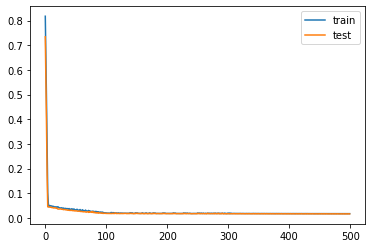

In [69]:
# design network
LSTM_model = Sequential()
LSTM_model.add(LSTM(5, input_shape=(train_input.shape[1], train_input.shape[2])))
LSTM_model.add(Dense(1))
LSTM_model.compile(loss='mae', optimizer='adam')
# fit network
history = LSTM_model.fit(train_input, train_output, batch_size = 1, epochs = 500, validation_data = (train_input, train_output), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [70]:
LSTM_result = LSTM_model.predict(train_input)

In [71]:
LSTM_result_2001to2019 = LSTM_model.predict(train_input_2001to2019)

### Visualize: SPY -- with SPMC Data

In [72]:
visualize_spy(LSTM_result, SPMC_SPY_relative_price_benchmark.iloc[:-1])

,Prediction,Original
Date,,
2008-09-02,0.973120,1.000000
2008-09-03,0.974585,0.999141
2008-09-04,0.965386,0.969060
2008-09-05,0.965388,0.972107
2008-09-08,0.966006,0.992187
2008-09-09,0.963381,0.962731
2008-09-10,0.961901,0.966638
2008-09-11,0.968104,0.980624
2008-09-12,0.965853,0.985155


### Visualize: SPY -- with 2001-01-02 ~ 2019-7-17 data

In [73]:
visualize_spy(LSTM_result_2001to2019, SPY_relative_prices.iloc[:-1])

,Prediction,Original
Date,,
2001-01-02,0.973120,1.000000
2001-01-03,0.995636,1.048035
2001-01-04,0.997003,1.036754
2001-01-05,0.987752,1.002911
2001-01-08,0.987515,1.010674
2001-01-09,0.991096,1.008006
2001-01-10,0.997524,1.025715
2001-01-11,1.000356,1.026686
2001-01-12,0.996436,1.024745
